## Краткое описание

Инвестиционная компания заказала анализ рынка компьютерных (консольных) игр. В анализ должны войти параметры, которые определяют успешность игры, что позволит сделать ставку на наиболее перспективные продукты и спланировать компании по продвижению.

## План выполнения работы

    Шаг 1. Изучение общей информации
    Шаг 2. Обработка данных
    Шаг 3. Исследовательский анализ данных
    Шаг 4. Составление портрета пользователей
    Шаг 5. Проверка гипотез
    Шаг 6. Общий вывод

## Описание данных

    Name — название игры
    Platform — платформа
    Year_of_Release (year)— год выпуска
    Genre — жанр игры
    NA_sales — продажи в Северной Америке (миллионы долларов)
    EU_sales — продажи в Европе (миллионы долларов)
    JP_sales — продажи в Японии (миллионы долларов)
    Other_sales — продажи в других странах (миллионы долларов)
    Critic_Score — оценка критиков (максимум 100)
    User_Score — оценка пользователей (максимум 10)
    Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

## Шаг 1. Изучение общей информации

In [550]:
import pandas as pd
from scipy import stats as st
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import math
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [551]:
games = pd.read_csv('/datasets/games.csv')

In [552]:
display(games.head(5))
games.info()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


В исходном датафрейме содержится 16715 записей, представляющих собой конкретную игру на каждой консоли в отдельности, с указанием жанра игры, продажами по регионам и рейтингами критиков и пользователей.
В таблице имеется достаточное количество пропусков, особенно в столбцах с оценками и рейтингом. Их причины возникновения будут рассмотрены ниже.

Типы данных столбцов "Год выхода" и "Оценка критиков" необходимо поменять на целочисленные.

## Шаг 2. Обработка данных

#### Переименование столбцов

In [553]:
#Заменим названия столбцов (приведем к нижнему регистру) и переименуем некоторые на более удобные
games.columns = games.columns.str.lower()
games.rename(columns={'year_of_release': 'year'}, inplace=True)
display(games.head(1))

,name,platform,year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E


#### Преобразование типов данных

In [554]:
#Преобразуем данные в нужные типы.
#В столбце с датой выхода мало пропусков (около 1.5%), поэтому удалим их, перед тем, как менять тип данных:
games = games.dropna(subset=['year'])
#Было желание взять дату из название игры и заменить пропуски этим значением, однако во-первых, пропусков мало,
#во-вторых, есть игры "Cyberpunk 2077", которые выбиваются из этой теории,
#а в-третьих, даже игры а-ля FIFA-2008 выходят с разницей +-год относительно названия.

#Меняем тип:
games['year'] = games['year'].astype('int64')

In [555]:
#Заменим NaN'ы на -1, для смены типа столбца.
games['critic_score'] = games['critic_score'].fillna(value='-1')
#Рейтинг критиков варьируется в диапозоне от 0 до 100, при этом значения целочисленные, поэтому заменим на int:
games['critic_score'] = games['critic_score'].astype('int64')
display(games.head(2))

,name,platform,year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1,NaN,NaN


#### Обработка пропусков

In [556]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16446 entries, 0 to 16714
Data columns (total 11 columns):
name            16444 non-null object
platform        16446 non-null object
year            16446 non-null int64
genre           16444 non-null object
na_sales        16446 non-null float64
eu_sales        16446 non-null float64
jp_sales        16446 non-null float64
other_sales     16446 non-null float64
critic_score    16446 non-null int64
user_score      9839 non-null object
rating          9768 non-null object
dtypes: float64(4), int64(2), object(5)
memory usage: 1.5+ MB


В столбце "Оценка критиков" пропуски уже заменили на "-1". Заполнение этих значений средним или медианой даже с группировкой по жанрам сильно исказит эти ключевые данные, поэтому делать так не будем. Было желание заменить пропуски у игр на одной консоли значениями из другой, но во-первых, у многих игр пропущены оценки для всех консолей, а во-вторых, рейтнги для разных консолей разнятся.

Рейтинг ESRB также может отличаться для разных консолей (разный уровень цензуры от разных вендоров), а игры в одном жанре могут сильно разниться (к жанру спорт могут относиться как футбол, так реслинг, которые имеют разные рейтинги).

In [557]:
#В столбце "Оценка критиков" уже заменили NaN'ы на "-1". Аналогично поступим с "Оценкой пользователей":
games['user_score'] = games['user_score'].fillna(value='-1')
#В столбце "Рейтинг" заменим NaN'ы на "unknown" для наглядности
games['rating'] = games['rating'].fillna(value='unknown')

In [558]:
#Рассмотрим детальнее рейтинг пользователей:
games['user_score'].value_counts().head(2)

-1     6607
tbd    2376
Name: user_score, dtype: int64

Помимо пропущенных значений с рейтингом игроков, есть значения "tbd", т.е. "to be announced". Данные игры находятся в стадии оценки и рейтинг пока не сформирован. Поскольку значения пока нет, заменим аналогично пропускам.

In [559]:
games['user_score'] = games['user_score'].fillna(value='-1')
games.loc[games['user_score'] == 'tbd','user_score'] = '-1'
games['user_score'] = games['user_score'].astype('float64')
games['user_score'].value_counts().head(2)

-1.0    8983
 7.8     322
Name: user_score, dtype: int64

Добавим столбец с продажами игры суммарно по всем регонам.

In [560]:
games['total_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']
games.head(3)

,name,platform,year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1,-1.0,unknown,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52


### Вывод

Пропуски присутствуют в играх, которые вышли достаточно давно, когда еще не было системы оценок со стороны критиков и игроков. А что касается столбца с рейтингом организации ESRB, то организация основана в 1994 году, поэтому масштабно оценивать игры они начали с конца 90-х - начала 2000-х.

Исходя из ряда объективных причин, описанных выше, пропуски не были заменены значениями, которые можно рассчитать исходя из предосталвенных данных. Однако были удалены неинформативные строки, которые составляли менее 2% данных, а пропуски в столбцах с "оценками" заменены на значения, выходящие из рассматриваемого нами в будующем диапозона.

Дополнительно был добавлен столбец с итоговами продажами по всем регионам для каждой игры.

### Шаг 3. Исследовательский анализ данных

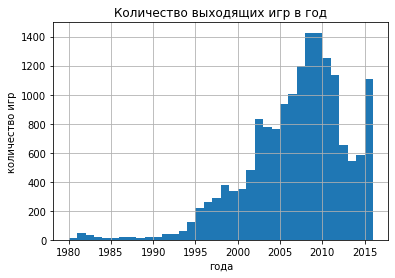

In [561]:
games.hist('year', bins = 36) #количество "корзин" = диапазону лет
plt.title('Количество выходящих игр в год')
plt.xlabel("года")
plt.ylabel("количество игр")
plt.show()

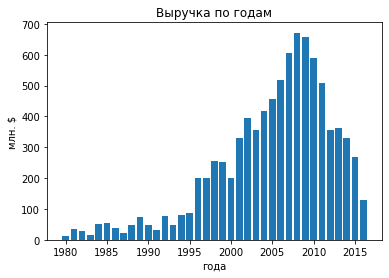

In [562]:
#Сгруппируем по году и просуммируем по итоговым продажам
games_sales = games.pivot_table(index=['year'], values='total_sales', aggfunc='sum').reset_index()
plt.bar(games_sales['year'], games_sales['total_sales'])
plt.title('Выручка по годам')
plt.xlabel("года")
plt.ylabel("млн. $")
plt.show()

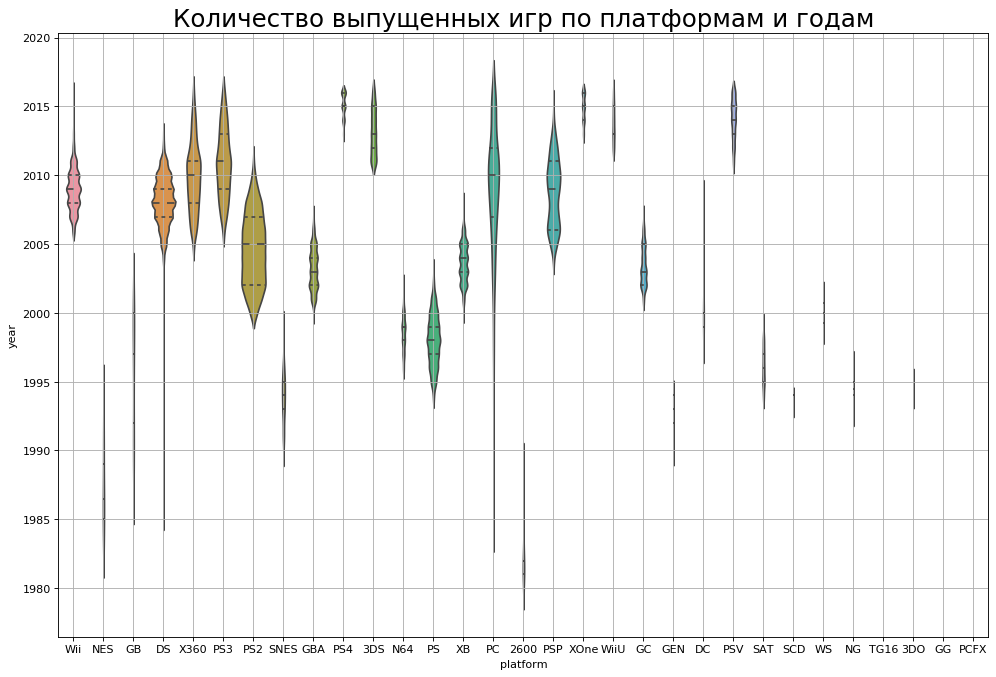

In [563]:
plt.figure(figsize=(15,10), dpi= 80)
sns.violinplot(x='platform', y='year', data=games, scale='count', inner='quartile')

# Decoration
plt.title('Количество выпущенных игр по платформам и годам', fontsize=22)
plt.grid()
plt.show()

Слишком много платформ для анализа. Выберем топ-7 по суммарным продажам и рассмотрим их отдельно.

In [564]:
games_platform = games.groupby('platform')['total_sales'].sum().reset_index()
games_platform.sort_values('total_sales', ascending=False).head(7) 

,platform,total_sales
16,PS2,1233.56
28,X360,961.24
17,PS3,931.34
26,Wii,891.18
4,DS,802.78
15,PS,727.58
18,PS4,314.14


Имеет смысл рассматривать не топ-5, а топ-7 платформ, поскольку разница по продажам между ними не столь велика, как между топ-6 другими.

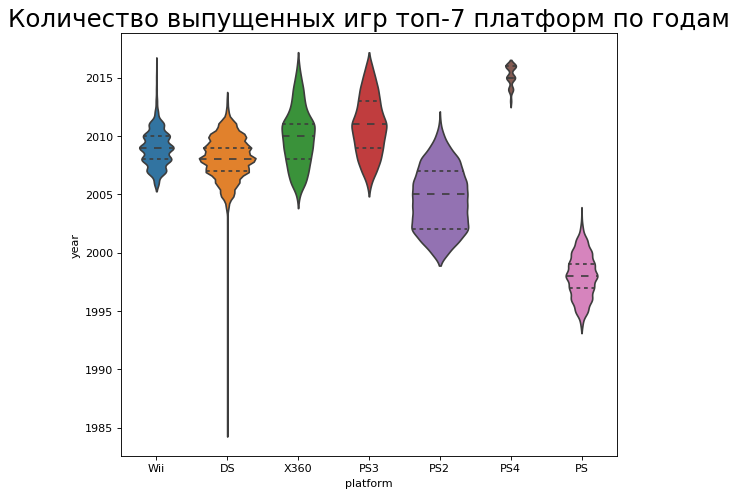

In [565]:
games_platform_top6 = games.query('platform in ("PS2", "X360", "PS3","DS", "Wii",  "PS", "PS4")')
plt.figure(figsize=(8,7), dpi= 80)
sns.violinplot(x='platform', y='year', data=games_platform_top6, scale='count', inner='quartile')

# Decoration
plt.title('Количество выпущенных игр топ-7 платформ по годам', fontsize=22)
plt.show()

In [566]:
#Дата выхода первой игры на платформе
platform_life_min = games.groupby('platform')['year'].min().reset_index()
#Дата выхода последней игры на платформе
platform_life_max = games.groupby('platform')['year'].max().reset_index()
#Объединим в одну таблицу
platform_life_time = platform_life_min.merge(platform_life_max, on='platform', how='right',suffixes=('_first','_last'))
#Рассчитаем "время жизни" приставки
platform_life_time['time_to_live'] = platform_life_time['year_last'] - platform_life_time['year_first'] + 1
# + 1 для округления лет в большую сторону
print("Топ-3 самых 'долгоживущих' платформ:")
display(platform_life_time.sort_values('time_to_live', ascending=False).head(3) )

Топ-3 самых 'долгоживущих' платформ:


,platform,year_first,year_last,time_to_live
13,PC,1985,2016,32
4,DS,1985,2013,29
5,GB,1988,2001,14


In [567]:
print("среднее время жизни платформ:", round(platform_life_time['time_to_live'].mean(), 1), "лет.")

среднее время жизни платформ: 8.6 лет.


In [568]:
#Актуальные игровые платформы:
platform_actual = platform_life_time.query('year_last == "2016"')
platform_actual

,platform,year_first,year_last,time_to_live
2,3DS,2011,2016,6
13,PC,1985,2016,32
17,PS3,2006,2016,11
18,PS4,2013,2016,4
20,PSV,2011,2016,6
26,Wii,2006,2016,11
27,WiiU,2012,2016,5
28,X360,2005,2016,12
30,XOne,2013,2016,4


Можно увидеть, что из всех приставок, на текущий момент актуальны всего 9. 

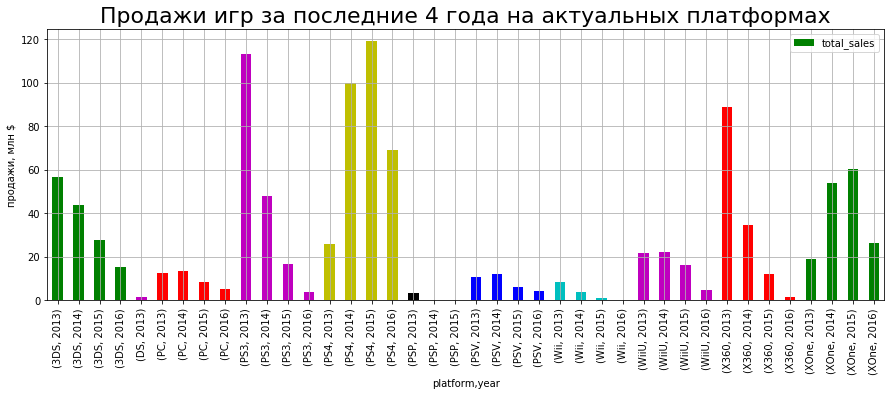

In [569]:
list_platform_actual = platform_actual['platform']
games_platform_actual = games.query('platform in @list_platform_actual')
games_platform_actual = games.query('year > 2012')
sales_actual_year = games_platform_actual.pivot_table(index=['platform','year'], values='total_sales', aggfunc='sum')
#sales_actual_year = sales_actual_year.reset_index()
# sales_actual_year.columns()
my_colors = 'ggggmrrrrmmmmyyyykkkbbbbccccmmmmrrrr'
sales_actual_year.plot(kind='bar', subplots=True, figsize=(15,5), color = my_colors, grid=True)
plt.title('Продажи игр за последние 4 года на актуальных платформах', fontsize=22)
plt.ylabel("продажи, млн $")
plt.show()


У многих топовых приставок, например PS3, виден заметный спад за последние 4 года.
Из всех приставок на текущий момент являются наиболее перспективными PS4 и XOne, поскольку их объемы продаж снизились заметно меньше остальных.

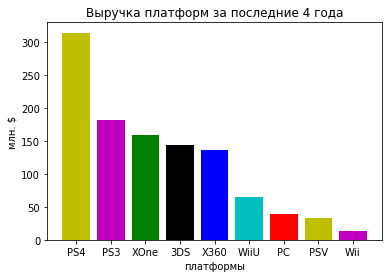

In [570]:
sales_actual_year_reset = sales_actual_year.reset_index()
top_sales_actual = sales_actual_year_reset.groupby('platform')['total_sales'].sum().reset_index()
top_sales_actual = top_sales_actual.sort_values('total_sales', ascending=False).head(9)
plt.bar(top_sales_actual['platform'], top_sales_actual['total_sales'], color='ymgkbcr')
plt.title('Выручка платформ за последние 4 года')
plt.xlabel("платформы")
plt.ylabel("млн. $")
plt.show()

Заметно, что имеются топ-5 платформ, которые существенно превосходят остальные по выручке. В свою очередь PS4 почти в 2 раза превышает по выручке даже платформы из топ-5.

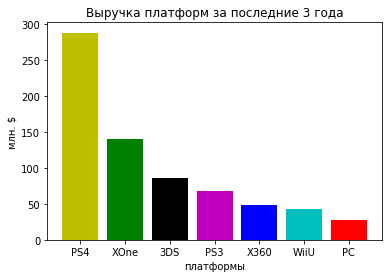

In [571]:
#топ платформ по продажам за последние 3 года:
top_actual_platform = games.query('year > 2013')
top_actual_platform = top_actual_platform.groupby('platform')['total_sales'].sum().reset_index()
top7_actual_platform = top_actual_platform.sort_values('total_sales', ascending=False).head(7)
plt.bar(top7_actual_platform['platform'], top7_actual_platform['total_sales'], color='ygkmbcr')
plt.title('Выручка платформ за последние 3 года')
plt.xlabel("платформы")
plt.ylabel("млн. $")
plt.show()

Теперь очевидно, что на рубеже 2012-2013 годов предпочтения по платформам резко изменились. Теория о том, что PS4 и XOne более перспективны подтверждаются. К фаворитам добавилась 3DS.

In [572]:
top_7 = top7_actual_platform['platform']
platform_top5_2011 = games.query('platform in @top_7')

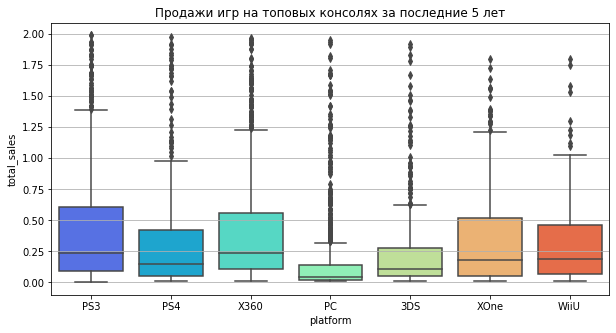

In [573]:
#Ящики с усами для топ-5 платформ за последние 5 лет:
platform_top5_2011 = platform_top5_2011.query('total_sales < 2') #для масштаба
plt.figure(figsize=(10,5))
plt.grid()
plt.title("Продажи игр на топовых консолях за последние 5 лет")
sns.boxplot(x="platform", y="total_sales", data=platform_top5_2011, palette='rainbow')

Средняя выручка для каждой игры у всех платформ около 0.2, хотя суммарная разница по продажам значительно отличается.

Поскольку наиболее перспективными являются приставки PS4 и XOne, то для анализа имеет смысл брать одну из них. В свою очередь у PS4 большая прибыль, поэтому остановимся на ней.

Как мы выяснили ранее, ситуация на рынке приставок начала резко меняться после 2013 года. Поэтому будем рассматривать данные в рамках актуального периода (3 года)

In [574]:
games_year_actual = games.query('year > 2013')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f816804cb90>,
      dtype=object)

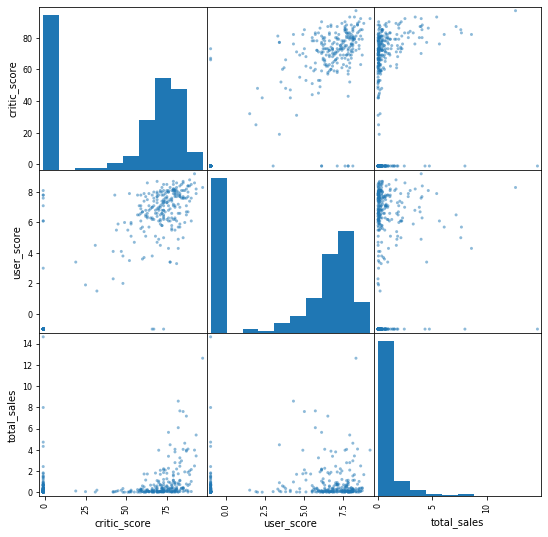

In [575]:
#выделим игры на PS4 в отдельный фрейм
ps4 = games_year_actual.query('platform == "PS4"')
#срез нужных нам столбцов
ps4_slice = ps4.loc[:,['critic_score', 'user_score', 'total_sales']]
ps4_slice['user_score']=ps4_slice['user_score'].astype('float64')
#матрица диаграмм рассеивания
pd.plotting.scatter_matrix(ps4_slice, figsize=(9,9))

На диаграммах видно, что у игр с высокими оценками критиков более высокие продажи. Оценки пользователей же более равномерно распределены по всему диапазано прибыли с игр.

In [576]:
#корреляция параметров
#уберем оценки "-1" из нашегей выборки для точности рассчета корреляции:
ps4_slice_2 = ps4_slice.query('user_score >= 0 & critic_score >= 0')
print("Корреляция оценок и цены игр на PS4")
display(ps4_slice_2.corr())

Корреляция оценок и цены игр на PS4


,critic_score,user_score,total_sales
critic_score,1.000000,0.546434,0.401903
user_score,0.546434,1.000000,-0.043186
total_sales,0.401903,-0.043186,1.000000


Итоговые продажи игры имеют прямую, но не очень сильную, корреляцию с рейтингами критиков (коэффициент корреляции = 0.4) и не коррелируют с оценками пользователей (к.к.= -0.04).

Посмотрим аналогичные показатели на других платформах

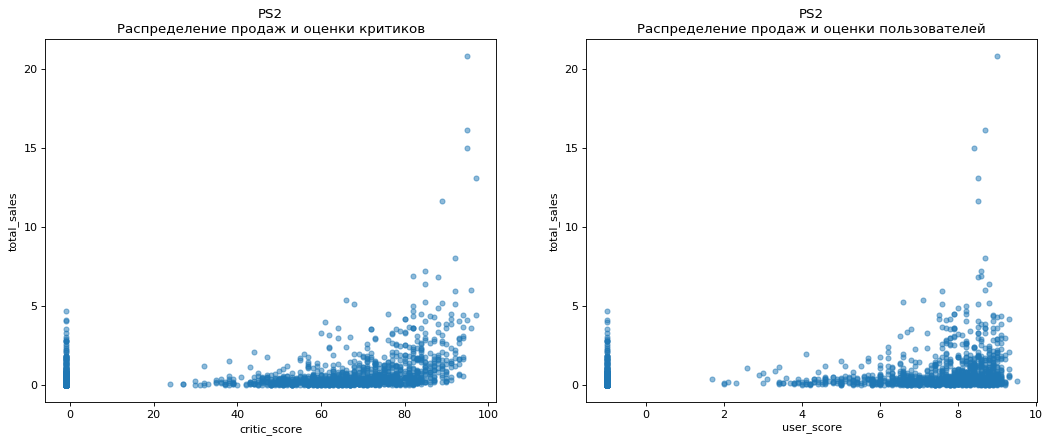

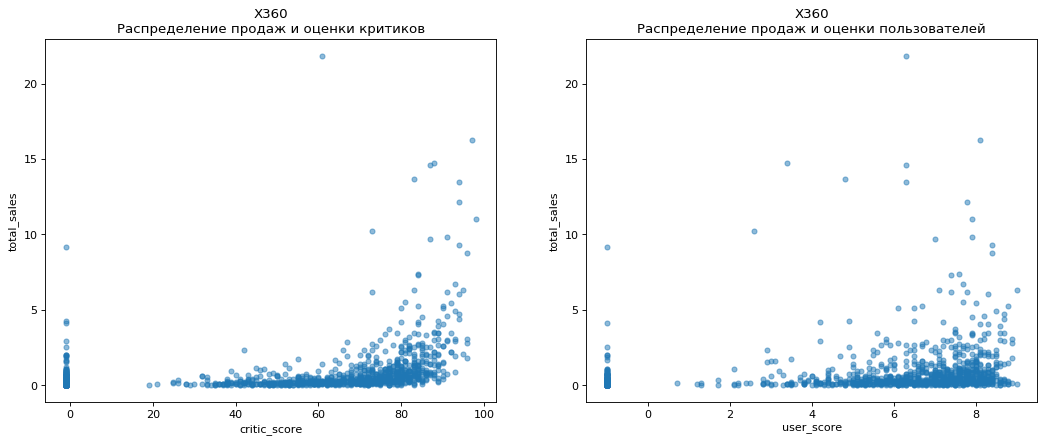

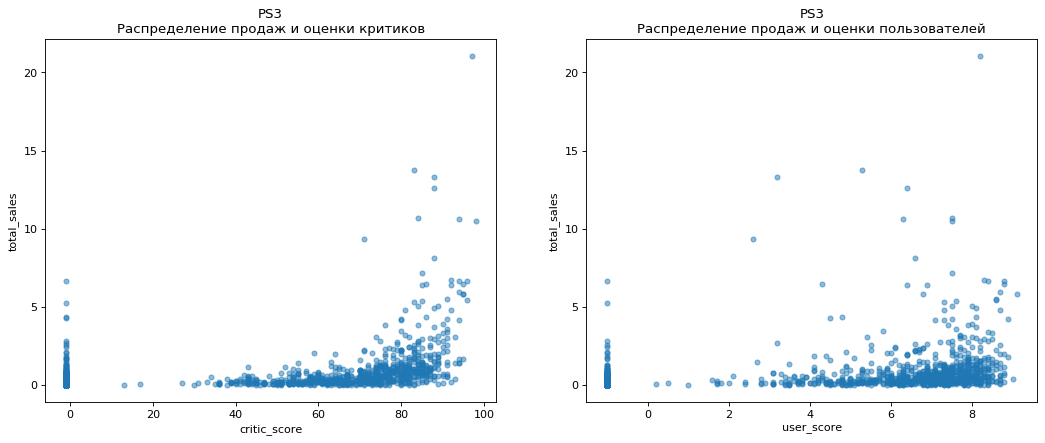

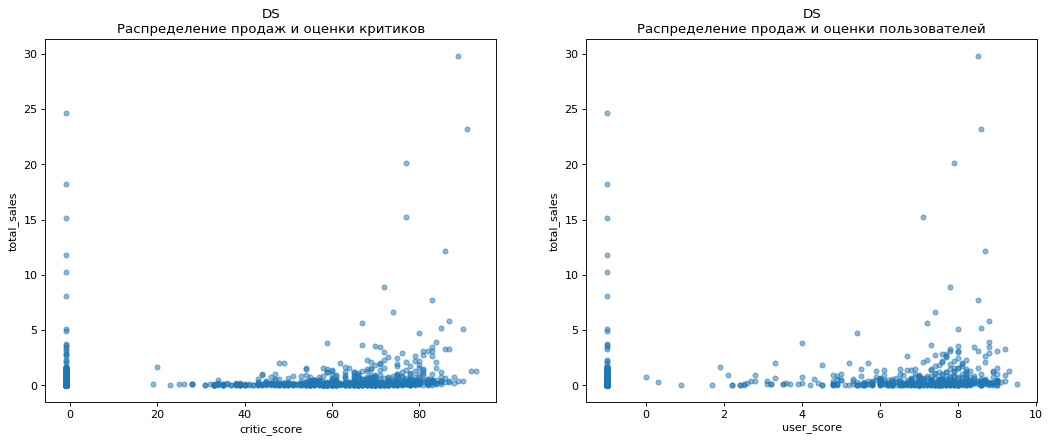

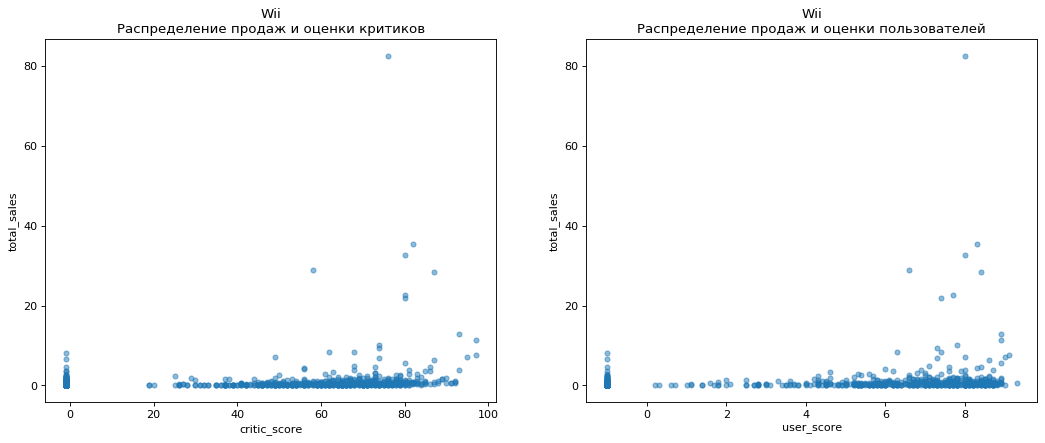

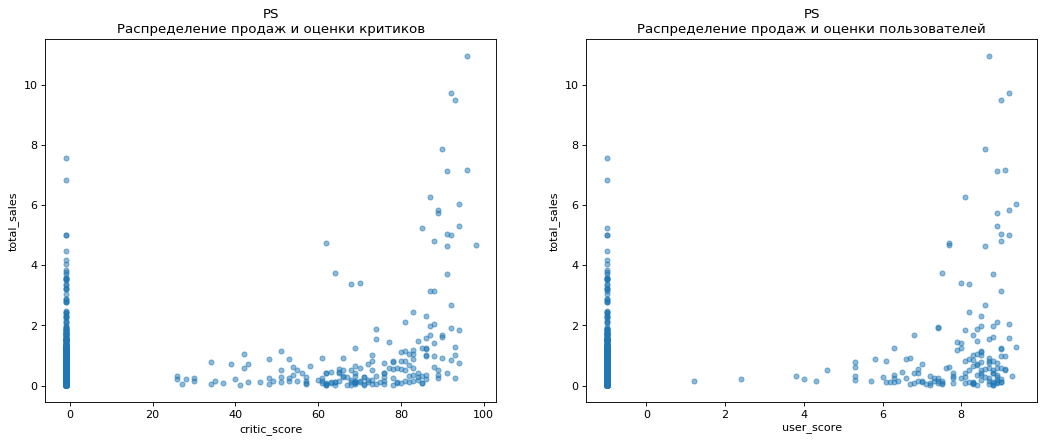

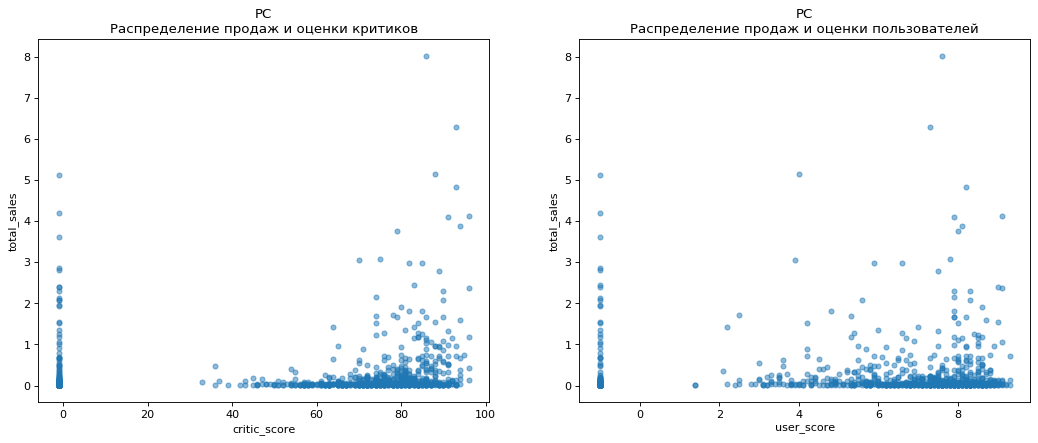

In [577]:
#pd.plot(games[['critic_score', 'user_score', 'total_sales']])
#Выыберем платформы из нашего топа: "PS2", "X360", "PS3","DS", "Wii",  "PS", "PC"
platform_top_list = ["PS2", "X360", "PS3","DS", "Wii",  "PS", "PC"]
for console in platform_top_list:
    games_query = games.query('platform == @console')
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,6), dpi= 80)
    games_query.plot(x='critic_score', ax=ax1, y ='total_sales', kind='scatter', alpha=0.5).set_title(console + '\nРаспределение продаж и оценки критиков')
    games_query.plot(x='user_score', ax=ax2, y ='total_sales', kind='scatter', alpha=0.5).set_title(console + '\nРаспределение продаж и оценки пользователей')
    

In [578]:
games_slice = games_year_actual.query('critic_score >= 0 & user_score >= 0')
display(games_slice[['critic_score', 'user_score', 'total_sales']].corr())

,critic_score,user_score,total_sales
critic_score,1.000000,0.504460,0.325363
user_score,0.504460,1.000000,0.005202
total_sales,0.325363,0.005202,1.000000


Зависимость продаж от оценки критиков у всех платформ вместе немного ниже, чем у PS4. Оценки пользователей также не коррелируют с продажами.

In [579]:
#список приставок с рейтингом:
games_not_null = games_year_actual.query('user_score != -1 or critic_score != -1')
platform = games_not_null['platform'].unique()

#пустой дф для цикла:
cor_all = pd.DataFrame() 

#цикл построения таблицы всех корреляций
for console in platform:
    games_query = games.query('platform == @console')
    games_slice = games_query.query('critic_score >= 0 & user_score >= 0')
#    display(games_slice[['critic_score', 'user_score', 'total_sales']].corr()['total_sales'])
    cor_one = []
    cor_one = games_slice[['critic_score', 'user_score', 'total_sales']].corr()
    cor_one.rename(columns={'total_sales': 'cor'}, inplace=True)
    cor_all = cor_all.join(cor_one['cor'], how='right', rsuffix="_" + console)
#трансформируем ДФ
cor_all = cor_all.T[1:]
#избавляемся от столбца с корреляцией цены от цены
cor_all = cor_all.loc[:, 'critic_score' : 'user_score']
cor_all.sort_values('user_score', ascending=False).head(5)

,critic_score,user_score
cor_WiiU,0.350882,0.391848
cor_3DS,0.338904,0.232089
cor_PS3,0.428213,0.143978
cor_Wii,0.170855,0.110637
cor_X360,0.388992,0.110280


В отличие от стационарных приставок, у портативных (WiiU, 3DS) рейтинги пользователей коррелируют с продажами (к.к. 0.2-0.4).

Посмотрим выручку игр в зависимости от жанра

In [580]:
genre_sum = games.groupby('genre')['total_sales'].sum().to_frame().reset_index()
genre_count = games_genre = games.groupby('genre')['total_sales'].count().to_frame().reset_index()
genre = genre_sum.merge(genre_count, on='genre', suffixes=('_sum', '_count'))
genre.columns = ['genre', 'sum', 'count']
genre['ratio'] = genre['sum'] / genre['count']
genre['ratio'] = round(genre['ratio'], 2)
#plt.bar(genre_sum)
genre.sort_values('sum', ascending=False)

,genre,sum,count,ratio
0,Action,1716.52,3307,0.52
10,Sports,1309.67,2306,0.57
8,Shooter,1041.36,1296,0.80
7,Role-Playing,931.08,1481,0.63
4,Platform,825.55,878,0.94
3,Misc,790.29,1721,0.46
6,Racing,723.49,1226,0.59
2,Fighting,442.66,837,0.53
9,Simulation,387.96,857,0.45
5,Puzzle,239.89,569,0.42


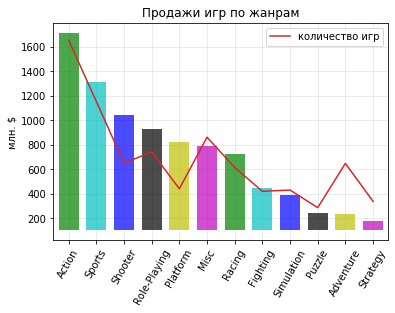

In [581]:
genre = genre.sort_values('sum', ascending=False)
genre['count_half'] = genre['count'] / 2 # столбец с количеством игр /2 для красоты на графике
plt.vlines(genre['genre'], genre['sum'],linestyles='solid', ymax =100, color='gcbkym', alpha=0.7, linewidth=20)
plt.plot('genre', 'count_half', data=genre, color='tab:red', label='количество игр')
plt.xticks(rotation=60, fontsize=10)
plt.title('Продажи игр по жанрам')
plt.ylabel("млн. $")
plt.grid(axis='both', alpha=.3)
plt.legend()
plt.show()

Самые частые игры жанра: Action, Sports и Misc, однако самые выпускаемые игры: Action, Sports и Shooter.

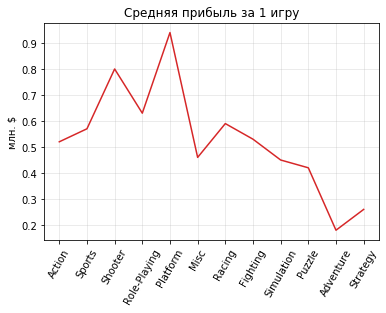

In [582]:
#Средняя цена одной игры конкретного жанра
plt.plot('genre', 'ratio', data=genre, color='tab:red')
plt.xticks(rotation=60, fontsize=10)
plt.title('Средняя прибыль за 1 игру')
plt.ylabel("млн. $")
plt.grid(axis='both', alpha=.3)
plt.show()

Лидеры продаваемости игры следующих жанров: Platform, Shooter, Role-Playing.

### Выводы

С каждым годом, вплоть до 2008, росло количество выпускаемых игр и их продажи. Начиная с 2010 заметна обратная тенденция.

Были рассмотрены около 30 платформ, однако на текущий момент, игры выходят лишь на 9 из них, более того, лишь пять приставок (PS4, PS3, XOne, 3DS, X360) занимаю львиную часть рынка последние 3 года.

В среднем, платформы живут 8.6 лет.

Средние продажи отдельных игр по всем консолям примерно равны 0.25 млн. $, хотя суммарная продажи отличаются более, чем в несколько раз.

Были рассмотрены зависимости продаж от оценок критиков и игроков на примере PS4 и других платформ. В целом, выводы идентичны: между продажами и оценками критиков есть прямая корреляционная связь (0.4), которая отсутствует между продажами и оценками игроков.

Самые прибыльные в абсолютных значениях жанры - Action, Sports и Misc. Самые выпускаемые - Action, Sports и Shooter. Самые прибыльные по средней цене за одну игру - Platform, Shooter, Role-Playing.

## Шаг 4. Составление портрета пользователей

Определите для пользователя каждого региона (NA, EU, JP):

    Самые популярные платформы (топ-5). Опишите различия в долях продаж.
    Самые популярные жанры (топ-5). Поясните разницу.
    Влияет ли рейтинг ESRB на продажи в отдельном регионе?

In [583]:
#Определим топ платформ в NA:
platform_na = games_year_actual.groupby('platform')['na_sales'].sum().to_frame().reset_index()
#Суммарно продаж по NA:
na_sum = games_year_actual['na_sales'].sum()
#Доля платформы
platform_na['ratio'] = platform_na['na_sales'] / na_sum * 100
platform_na['ratio'] = platform_na['ratio'].astype('int64')
platform_na_sort = platform_na.sort_values('na_sales', ascending=False).head(5)
platform_na_sort

,platform,na_sales,ratio
3,PS4,98.61,34
9,XOne,81.27,28
8,X360,28.30,9
0,3DS,22.64,7
2,PS3,22.05,7


In [584]:
#Определим топ платформ в EU:
platform_eu = games_year_actual.groupby('platform')['eu_sales'].sum().to_frame().reset_index()
platform_eu.sort_values('eu_sales', ascending=False).head(5)
#Сумма по EU
eu_sum = games_year_actual['eu_sales'].sum()
#Доля платформы
platform_eu['ratio'] = platform_eu['eu_sales'] / eu_sum * 100
platform_eu['ratio'] = platform_eu['ratio'].astype('int64')
platform_eu_sort = platform_eu.sort_values('eu_sales', ascending=False).head(5)
platform_eu_sort

,platform,eu_sales,ratio
3,PS4,130.04,48
9,XOne,46.25,17
2,PS3,25.54,9
1,PC,17.97,6
0,3DS,16.12,5


In [585]:
#Определим топ платформ в JP:
platform_jp = games_year_actual.groupby('platform')['jp_sales'].sum().to_frame().reset_index()
platform_jp.sort_values('jp_sales', ascending=False).head(5)
#Продажи по JP:
jp_sum = games_year_actual['jp_sales'].sum()
#Доля платформы
platform_jp['ratio'] = platform_jp['jp_sales'] / jp_sum * 100
platform_jp['ratio'] = platform_jp['ratio'].astype('int64')
platform_jp_sort = platform_jp.sort_values('jp_sales', ascending=False).head(5)
platform_jp_sort

,platform,jp_sales,ratio
0,3DS,44.24,47
3,PS4,15.02,16
5,PSV,14.54,15
2,PS3,11.22,12
7,WiiU,7.31,7


In [586]:
#Функция построения пирога платформ:
def pie(data, categories, locality):
    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(aspect="equal"), dpi= 80)
    
    def func(pct, allvals):
        absolute = int(pct/100.*np.sum(allvals))
        return "{:.1f}% ({:d} )".format(pct, absolute)
    
    wedges, texts, autotexts = ax.pie(data, 
                                      autopct=lambda pct: func(pct, data),
                                      textprops=dict(color="w"), 
                                      colors=plt.cm.Dark2.colors,
                                     startangle=140)
    
    # Decoration
    ax.legend(wedges, categories, title="Обозначения платформ:", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
    plt.setp(autotexts, size=10, weight=700)
    ax.set_title("Топ-5 платформ в " + locality)
    plt.show()

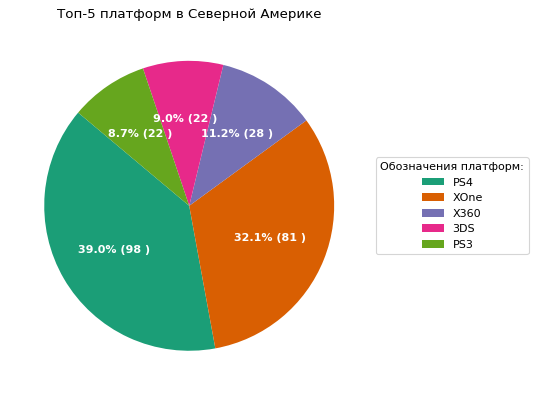

In [587]:
#NA
data = platform_na_sort['na_sales']
categories = platform_na_sort['platform']
locality = 'Северной Америке'
pie(data, categories, locality)

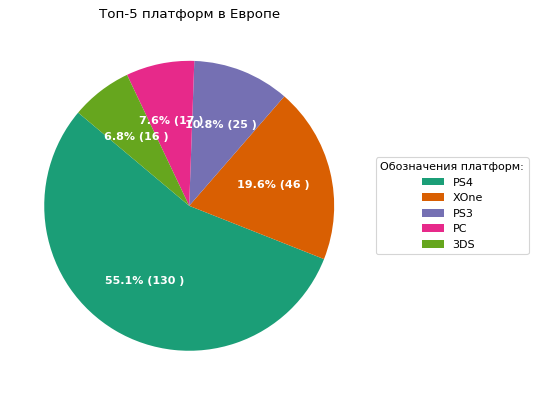

In [588]:
#EU
data = platform_eu_sort['eu_sales']
categories = platform_eu_sort['platform']
locality = 'Европе'
pie(data, categories, locality)

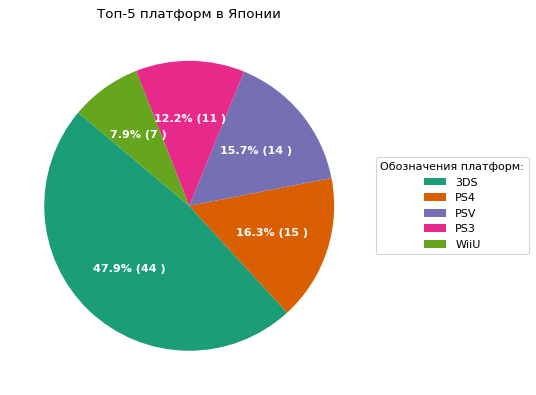

In [589]:
#EU
data = platform_jp_sort['jp_sales']
categories = platform_jp_sort['platform']
locality = 'Японии'
pie(data, categories, locality)

In [590]:
#Аналогично определим самые поплурные жанры за последние 9 лет
#NA
genre_na = games_year_actual.groupby('genre')['na_sales'].sum().to_frame().reset_index()
genre_na.sort_values('na_sales', ascending=False).head(5)
#Продажи по JP:
na_sum = games_year_actual['na_sales'].sum()
#Доля жанра
genre_na['ratio'] = genre_na['na_sales'] / na_sum * 100
genre_na['ratio'] = genre_na['ratio'].astype('int64')
genre_na_sort = genre_na.sort_values('na_sales', ascending=False).head(5)
genre_na_sort

,genre,na_sales,ratio
8,Shooter,79.02,27
0,Action,72.53,25
10,Sports,46.13,16
7,Role-Playing,33.47,11
3,Misc,15.05,5


In [591]:
#EU
genre_eu = games_year_actual.groupby('genre')['eu_sales'].sum().to_frame().reset_index()
genre_eu.sort_values('eu_sales', ascending=False).head(5)
#Продажи по EU:
eu_sum = games_year_actual['eu_sales'].sum()
#Доля жанра
genre_eu['ratio'] = genre_eu['eu_sales'] / eu_sum * 100
genre_eu['ratio'] = genre_eu['ratio'].astype('int64')
genre_eu_sort = genre_eu.sort_values('eu_sales', ascending=False).head(5)
genre_eu_sort

,genre,eu_sales,ratio
0,Action,74.68,27
8,Shooter,65.52,24
10,Sports,45.73,16
7,Role-Playing,28.17,10
6,Racing,14.13,5


In [592]:
#Япония
genre_jp = games_year_actual.groupby('genre')['jp_sales'].sum().to_frame().reset_index()
genre_jp.sort_values('jp_sales', ascending=False).head(5)
#Продажи по JP:
jp_sum = games_year_actual['jp_sales'].sum()
#Доля жанра
genre_jp['ratio'] = genre_jp['jp_sales'] / jp_sum * 100
genre_jp['ratio'] = genre_jp['ratio'].astype('int64')
genre_jp_sort = genre_jp.sort_values('jp_sales', ascending=False).head(5)
genre_jp_sort

,genre,jp_sales,ratio
7,Role-Playing,31.16,33
0,Action,29.58,31
2,Fighting,6.37,6
3,Misc,5.61,6
8,Shooter,4.87,5


In [593]:
#Функция построения пирога жанра:
def pie(data, categories, locality):
    fig, ax = plt.subplots(figsize=(12, 7), subplot_kw=dict(aspect="equal"), dpi= 80)
    
    def func(pct, allvals):
        absolute = int(pct/100.*np.sum(allvals))
        return "{:.1f}% ({:d} )".format(pct, absolute)
    
    wedges, texts, autotexts = ax.pie(data, 
                                      autopct=lambda pct: func(pct, data),
                                      textprops=dict(color="w"), 
                                      colors=plt.cm.Dark2.colors,
                                     startangle=140)
    
    # Decoration
    ax.legend(wedges, categories, title="Жанры:", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
    plt.setp(autotexts, size=10, weight=700)
    ax.set_title("Топ-5 жанров в " + locality)
    plt.show()

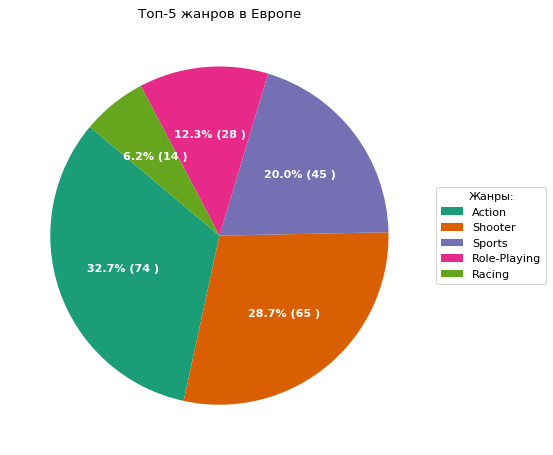

In [594]:
#EU
data = genre_eu_sort['eu_sales']
categories = genre_eu_sort['genre']
locality = 'Европе'
pie(data, categories, locality)

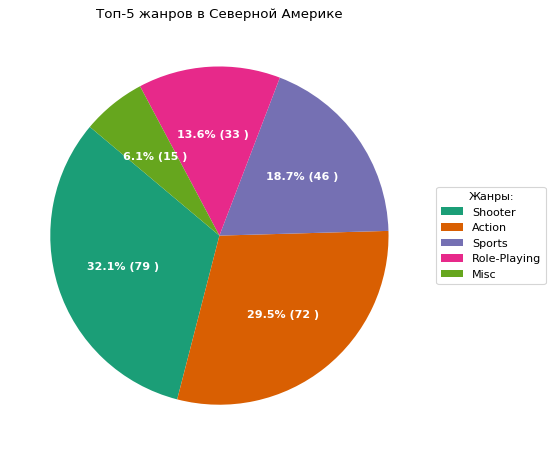

In [595]:
#NA
data = genre_na_sort['na_sales']
categories = genre_na_sort['genre']
locality = 'Северной Америке'
na_2 = pie(data, categories, locality)

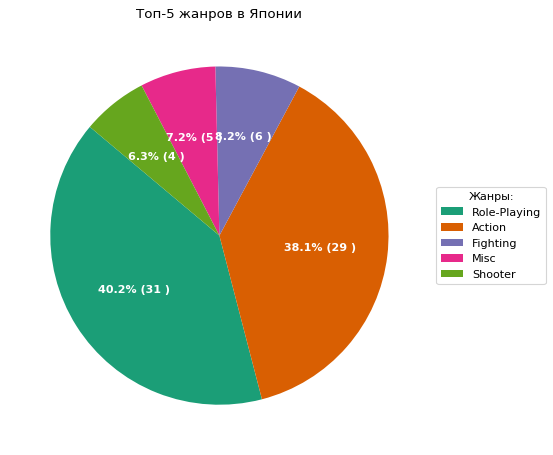

In [596]:
#JP
data = genre_jp_sort['jp_sales']
categories = genre_jp_sort['genre']
locality = 'Японии'
jp_2 = pie(data, categories, locality)

In [597]:
platform_total = platform_na.merge(platform_eu, on='platform', how='left', suffixes=('_na', '_eu'))
platform_total = platform_total.merge(platform_jp, on='platform', how='left')
platform_total.rename(columns={'ratio': 'ratio_jp'}, inplace=True)
print("Итоговая таблица по платформам в регионах с 2014 года")
platform_total.sort_values('na_sales', ascending=False).head(9)

Итоговая таблица по платформам в регионах с 2014 года


,platform,na_sales,ratio_na,eu_sales,ratio_eu,jp_sales,ratio_jp
3,PS4,98.61,34,130.04,48,15.02,16
9,XOne,81.27,28,46.25,17,0.32,0
8,X360,28.30,9,15.49,5,0.08,0
0,3DS,22.64,7,16.12,5,44.24,47
2,PS3,22.05,7,25.54,9,11.22,12
7,WiiU,19.36,6,13.15,4,7.31,7
1,PC,7.23,2,17.97,6,0.00,0
5,PSV,2.52,0,3.53,1,14.54,15
6,Wii,2.08,0,2.59,0,0.00,0


In [598]:
genre_total = genre_na.merge(genre_eu, on='genre', how='left', suffixes=('_na', '_eu'))
genre_total = genre_total.merge(genre_jp, on='genre', how='left')
genre_total.rename(columns={'ratio': 'ratio_jp'}, inplace=True)
print("Итоговая таблица по жанрам в регионах:")
genre_total.sort_values('na_sales', ascending=False).head(9)

Итоговая таблица по жанрам в регионах:


,genre,na_sales,ratio_na,eu_sales,ratio_eu,jp_sales,ratio_jp
8,Shooter,79.02,27,65.52,24,4.87,5
0,Action,72.53,25,74.68,27,29.58,31
10,Sports,46.13,16,45.73,16,3.26,3
7,Role-Playing,33.47,11,28.17,10,31.16,33
3,Misc,15.05,5,12.86,4,5.61,6
2,Fighting,12.43,4,6.69,2,6.37,6
6,Racing,8.74,3,14.13,5,1.76,1
4,Platform,6.79,2,6.80,2,2.69,2
1,Adventure,5.64,1,6.49,2,3.60,3


In [599]:
#esrb в мире
region_esrb = games_year_actual.groupby('rating')['total_sales'].sum().to_frame().reset_index()
#esrb в na
na_esrb = games_year_actual.groupby('rating')['na_sales'].sum().to_frame().reset_index()
#esrb в eu
eu_esrb = games_year_actual.groupby('rating')['eu_sales'].sum().to_frame().reset_index()
#esrb в jp
jp_esrb = games_year_actual.groupby('rating')['jp_sales'].sum().to_frame().reset_index()
#merge
total_esrb = region_esrb.merge(na_esrb, on='rating', how='left')
total_esrb = total_esrb.merge(eu_esrb, on='rating', how='left')
total_esrb = total_esrb.merge(jp_esrb, on='rating', how='left')
total_esrb.sort_values('total_sales', ascending=False)

,rating,total_sales,na_sales,eu_sales,jp_sales
2,M,226.54,96.42,93.44,8.01
4,unknown,198.97,64.72,58.95,56.90
0,E,133.13,50.74,58.06,8.94
3,T,99.13,38.95,34.07,14.78
1,E10+,71.68,33.23,26.16,4.46


### Вывод

В Европе и Северной Америке топ-5 платформ одинаков и состоит из платформ PS3, X360, Wii, PS4, DS, при этом PS4 и DS занимают 4 и 5 строчки. В Японии топ-5 несколько иной: DS, 3DS, PS3, PSP, Wii. Таким образом в Северной Америке и Европе преоблаают стационарные консоли, а в Японии портативные.

По игровым жанрам Япония тоже отличается: западные страны отдают предпочтение жанрам Action и Shooter, в то время как японцы предпочитают Role-Playing.

И даже в рейтинге ESRB японцы отличились: в Северной Америке и Европе предпочтение рейтингу "Е" ("Для всех") и "М" ("Для взрослых"), в то время как у японцев преобладают игры без рейтинга, "Е" и "Т" ("Для подростков").

## Шаг 5. Проверка гипотез


Гипотеза №1: средние пользовательские рейтинги платформ Xbox One и PC различаются.

Гипотеза №2: средние пользовательские рейтнги жанров Action и Sports разные.

Гипотеза №1:

    Нулевая гипотеза: средние пользовательские рейтинги платформ Xbox One и PC равны.
    Альтернативная гипотеза: средние пользовательские рейтинги платформ Xbox One и PC не равны.


In [600]:
alpha = 0.01 # критический уровень статистической значимости
#Игры на хбох за последние 3 года
xbox_games = games_year_actual.query('platform == "XOne"')
xbox_games = xbox_games.query('user_score >= 0')
#Игры на пк за последние 3 года
pc_games = games_year_actual.query('platform == "PC"')
pc_games = pc_games.query('user_score >= 0')

hypo_1 = st.ttest_ind(
    xbox_games[['user_score']], 
    pc_games[['user_score']])
print('p-значение:', hypo_1.pvalue)

if (hypo_1.pvalue < alpha):
    print("Отвергаем гипотезу о равенстве средних пользовательских рейтингов")
else:
    print("Не получилось отвергнуть гипотезу о равенстве средних пользовательских рейтингов")

p-значение: [0.10450508]
Не получилось отвергнуть гипотезу о равенстве средних пользовательских рейтингов


Гипотеза №2:

    Нулевая гипотеза: средние пользовательские рейтинги жанров Action и Sports равны.
    Альтернативная гипотеза: средние пользовательские рейтинги жанров Action и Sports не равны.

In [601]:
alpha = 0.01 # критический уровень статистической значимости

#Игры Экшен за последние 9 лет
action_games = games_year_actual.query('genre == "Action"')
#Игры Спорт за последние 9 лет
sport_games = games_year_actual.query('genre == "Sports"')

hypo_2 = st.ttest_ind(
    action_games[['user_score']], 
    sport_games[['user_score']])
print('p-значение:', hypo_2.pvalue)

if (hypo_2.pvalue < alpha):
    print("Отвергаем гипотезу о равенстве средних пользовательских рейтингов жанров Action и Sports")
else:
    print("Не получилось отвергнуть гипотезу о равенстве средних пользовательских рейтингов жанров Action и Sports")

p-значение: [0.0004666]
Отвергаем гипотезу о равенстве средних пользовательских рейтингов жанров Action и Sports


### Вывод

Были проверены две теории о равенстве средних пользовательских оценок: на приставках Xbox One и PC; жанров Action и Спорт.

    Первая теория не была опровергнута, то есть не удалось опровергнуть, что средние пользовательские оценки на Xbox One и на PC различаются.
    Вторая теория была опровергнута, то есть средние пользовательские оценки жанров Action и Sport различается.

Для проверки гипотез применили метод scipy.stats.ttest_ind(), поскольку сравнивались средние двух независимые генеральных совокупностей по взятым из них выборкам (данные за 2016 год могут быть неполными).


## Шаг 6. Общий вывод

В ходе данного проекта были проанализированы имеющиеся данные по играм, вышедшим до 2016 года включительно.

В ходе исследования были определены актуальные игровые платформы и выделены наболее перспективные из них (PS4 и Xbox One для запада и 3DS для Японии). Средние продажи каждой игры на всех платформах примерно равны 0.2 млн $, однако за счет количества и "выбросов" некоторые консоли опережают по абсолютным продажам остальные в несколько раз (например, PS4 продала в 2 раза больше любой другой приставки за последние 4 года).

Было выявлено, что оценки критиков у стационарных консолей имеют прямую корреляционную связь с продажами (коэффициент 0.4), в отличие от пользовательских оценок (коэффикицент ~ 0). Для портативных консолей эти коэффициенты равны 0.4 и 0.3 соответственно.

Самые выпускаемые и продаваемые жанры - Action и Sports, однако самые успешные жанры исходя из средней продажи одной игры -   Platform, Shooter.

Были составлены портреты пользователей: В северной Америке и Европе отдают предпочтение стационарным консолям и играм в жанре Action, Shooter и Sport с рейтнгом "E" и "M", в то время как в Японии предпочитают портативные игровые консоли и игры жанра Role-Playing c рейтнгом "E" и "T".

Были выдвинуты две теории косательно пользовательских оценок. Теория о равенстве пользовательских оценок на платформах Xbox One и PC и играх жанров Action и Sport. Вторая теория была опровергнута. 